In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---
### Sub：Metrics

In [212]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [213]:
def rmse(y_pred, y_true):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

In [214]:
def showPlot(true, prediction, model , test_set, size='M', save=False):
    if(size=='L'):
        plt.figure(figsize=(28, 10))
    plt.plot(true, color = 'red', label = 'Real')
    plt.plot(prediction, color = 'blue', label = 'Prediction')
    plt.title('Industry Elec Prediction' + model + ' ' + test_set + ' t' + str(t))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    if(save):
        plt.savefig('Image/' + model + '-' + test_set + '-' + str(t) + '.jpeg')
    plt.show()


---
### Sub：Data

In [215]:
# 20160101~20161231 [0~366]
# 20170101~20171231 [366~731]
# 20180101~20181231 [731~1095]
# 20190101~20190930 [1096~1368]
# df = pd.read_csv('Data/elec_merge_20160101_20190930.csv')
df = pd.read_csv('Data/industryElec_processed_20170101_20190930.csv')
df.shape

(1003, 12)

In [216]:
df.head()

,日期,尖峰負載(MW),工業用電(百萬度),isHoliday,week,week_update,dayOfYear,Temp_Taipei,Temp_Taipei_shift,isHoliday_shift,尖峰負載(MW)_shift,weekUpdate_shift
0,2017-01-01,22886,268.503,1.0,7,7,1,17.5,15.8,1.0,24133.0,7.0
1,2017-01-02,24483,280.534,1.0,1,7,2,17.1,11.9,0.0,27670.0,1.0
2,2017-01-03,28131,320.449,0.0,2,1,3,16.6,13.1,0.0,27787.0,2.0
3,2017-01-04,28485,329.623,0.0,3,3,4,18.5,14.2,0.0,27992.0,3.0
4,2017-01-05,28336,330.137,0.0,4,4,5,18.0,15.5,0.0,28186.0,4.0


In [217]:
# features = ["工業用電(百萬度)", "民生用電(百萬度)",
#             "isHoliday", "isHoliday(Next7)",
#             "尖峰負載(MW)", "淨尖峰供電能力(MW)", 
#             "備轉容量(MW)", "備轉容量率(%)"]
features = ["工業用電(百萬度)",
            "isHoliday", "isHoliday_shift",
            "week",
            "尖峰負載(MW)"]
oneHot_features = ["week"]
# features = ["工業用電(百萬度)"]

In [218]:
def augFeatures(data, features_select=features):
    # 訓練資料擷取
    data = pd.DataFrame(data[features_select])
    data.shape
    return data

In [219]:
from sklearn.preprocessing import MinMaxScaler
def normalize(train):
    # Feature Scaling
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(train)
    return sc, training_set_scaled 

In [247]:
# Use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
def oneHot(train, oneHot_features=oneHot_features):
    oneHot_set = pd.DataFrame(train[oneHot_features])
    train=train.drop(columns=oneHot_features)
    # Build encoder
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit_transform(oneHot_set)
    train_onehot = enc.transform(oneHot_set).toarray()
    train_onehot = pd.DataFrame(train_onehot)

    train = pd.concat([train.reset_index(), train_onehot.reset_index()], axis = 1)
    train=train.drop(columns=["index"])
    return train

In [237]:
def buildTrain(train, pastDay=7, futureDay=7):
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])

    # 轉成numpy array的格式，以利輸入 RNN    
    X_train, Y_train = np.array(X_train), np.array(Y_train)  

    # Reshape
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    print('X_train.shape', X_train.shape)
    print('Y_train.shape', Y_train.shape)
    return X_train, Y_train

In [238]:
def buildTest(startDate, sc, pastDay, futureDay, pre_step):
    dataset_total = df[(startDate-pastDay):(startDate-pastDay)+(pre_step*pastDay)]
    dataset_total = augFeatures(dataset_total)
    
    inputs = dataset_total
#     inputs = inputs.reshape(-1, dataset_total.shape[1])
    
    # OneHot
    inputs = oneHot(inputs)

    # Feature Scaling
    inputs = sc.transform(inputs)
    
    X_test = []
    for i in range(0, pre_step):
        X_test.append(inputs[pastDay*i:pastDay*(i+1)])
    X_test = np.array(X_test)

    # Reshape
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  
    print('X_test.shape', X_test.shape)
    return X_test

In [223]:
def shuffle(X, Y):
#     np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [224]:
def splitData(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

---
### Sub：Model

In [225]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import CuDNNLSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import BatchNormalization, Bidirectional
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [226]:
def buildModelcLSTM(shape, dropout_rate=0.1):
    # Initialising the LSTM
    model = Sequential()
    # Adding the first LSTM layer and some Dropout regularisation
    model.add(CuDNNLSTM(units = 256, return_sequences = True, input_shape = (shape[1], shape[2])))
    model.add(Dropout(dropout_rate))
#     model.add(CuDNNLSTM(units = 128, return_sequences = True))
#     model.add(Dropout(dropout_rate))
    model.add(Flatten())
    # Adding the output layer
    model.add(Dense(units = 7))
    
    model.summary()
    return model

---
### Main

In [249]:
# 資料選取
# RawTrain = df[366:1096]
# RawTest = df[1096:]
RawTrain = df[0:730]
RawTest = df[730:]

# 特徵選取
training_set = augFeatures(RawTrain)

# OneHot
training_set_oneHot = oneHot(training_set)

# 資料前處理
sc, training_set_scaled = normalize(training_set_oneHot)

# 自定義變數
Timesteps = 7
OutputDay = 7

# 資料打包
X_train, Y_train = buildTrain(training_set_scaled, Timesteps, OutputDay)

# 資料亂序
# X_train, Y_train = shuffle(X_train, Y_train)

# 驗證資料
# X, Y, Xv, Yv= splitData(X_train, Y_train, 0.1)

X_train.shape (716, 7, 11)
Y_train.shape (716, 7)


C:\Users\siang\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [250]:
model = buildModelcLSTM(X_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_6 (CuDNNLSTM)     (None, 7, 256)            275456    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 12551     
Total params: 288,007
Trainable params: 288,007
Non-trainable params: 0
_________________________________________________________________


In [251]:
from keras import optimizers
# initialize optimizer
# optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.0001), metrics=['mape'])
# Model.compile(loss='mean_squared_error', optimizer=RMSprop())
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')
# model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])

In [252]:
# callback reduce_lr
# cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=15, mode='auto', verbose=1)
# callback cb_EarlyStop
cb_EarlyStop = EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="auto")

In [253]:
batch_size = 16
epochs = 100

history = model.fit(X_train, Y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1, 
                    shuffle=False,
#                     callbacks=[cb_reduce_lr],
#                     callbacks=[cb_reduce_lr, cb_EarlyStop],
                    validation_split=0.1)

Train on 644 samples, validate on 72 samples
Epoch 1/100
644/644 [==============================] - 1s 2ms/step - loss: 0.0440 - val_loss: 0.0052
Epoch 2/100
644/644 [==============================] - 0s 407us/step - loss: 0.0212 - val_loss: 0.0048
Epoch 3/100
644/644 [==============================] - 0s 400us/step - loss: 0.0243 - val_loss: 0.0088
Epoch 4/100
644/644 [==============================] - 0s 397us/step - loss: 0.0218 - val_loss: 0.0094
Epoch 5/100
644/644 [==============================] - 0s 407us/step - loss: 0.0158 - val_loss: 0.0051
Epoch 6/100
644/644 [==============================] - 0s 414us/step - loss: 0.0115 - val_loss: 0.0028
Epoch 7/100
644/644 [==============================] - 0s 419us/step - loss: 0.0102 - val_loss: 0.0030
Epoch 8/100
644/644 [==============================] - 0s 445us/step - loss: 0.0116 - val_loss: 0.0044
Epoch 9/100
644/644 [==============================] - 0s 467us/step - loss: 0.0121 - val_loss: 0.0044
Epoch 10/100
644/644 [========

644/644 [==============================] - 0s 385us/step - loss: 0.0047 - val_loss: 0.0027
Epoch 80/100
644/644 [==============================] - 0s 386us/step - loss: 0.0048 - val_loss: 0.0028
Epoch 81/100
644/644 [==============================] - 0s 382us/step - loss: 0.0051 - val_loss: 0.0028
Epoch 82/100
644/644 [==============================] - 0s 380us/step - loss: 0.0050 - val_loss: 0.0028
Epoch 83/100
644/644 [==============================] - 0s 382us/step - loss: 0.0050 - val_loss: 0.0030
Epoch 84/100
644/644 [==============================] - 0s 385us/step - loss: 0.0047 - val_loss: 0.0024
Epoch 85/100
644/644 [==============================] - 0s 405us/step - loss: 0.0049 - val_loss: 0.0030
Epoch 86/100
644/644 [==============================] - 0s 396us/step - loss: 0.0047 - val_loss: 0.0026
Epoch 87/100
644/644 [==============================] - 0s 420us/step - loss: 0.0045 - val_loss: 0.0025
Epoch 88/100
644/644 [==============================] - 0s 417us/step - loss:

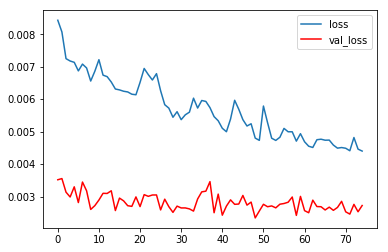

In [254]:
plt.plot(history.history['loss'][25:], label = 'loss')
plt.plot(history.history['val_loss'][25:], color = 'red', label = 'val_loss')
plt.legend()
plt.show()

---
## Time

In [255]:
t = 5
# save = True
save = False
model_name = '(LSTM_2017_F5)'

---
## Load Model

In [256]:
# # load
# from keras.models import load_model
# model = load_model('Model/industryElec_cLSTM(7to7)_model_0' + str(t) + '.h5')

---
## Self-Prediction

In [257]:
# true
# self_true = pd.DataFrame(training_set[["工業用電(百萬度)"]])[0:1092].values[Timesteps:,]
self_true = pd.DataFrame(training_set[["工業用電(百萬度)"]])[0:721].values[Timesteps:,]
# self_train = buildTest(0+7, sc, Timesteps, OutputDay, int(len(self_true)/7))
self_train = buildTest(7, sc, Timesteps, OutputDay, int(len(self_true)/7))

X_test.shape (102, 7, 11)


In [258]:
# predict
self_predict = model.predict(self_train)
self_predict = self_predict * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
self_prediction = []
# Type A
for i in range(int(len(self_true)/7)):
    self_prediction= np.concatenate((self_prediction, self_predict[i]), axis=0)
# Type B
# for i in range(len(self_true)):
#     self_prediction=np.append(self_prediction, np.array(self_predict[i][0]))

# Reshape
self_prediction = np.reshape(self_prediction, (self_true.shape[0], self_true.shape[1]))
print('self_true.shape', self_true.shape)
print('self_prediction.shape', self_prediction.shape)

self_true.shape (714, 1)
self_prediction.shape (714, 1)


RMSE:  10.584041245935154
MAPE:  2.4964949939441787


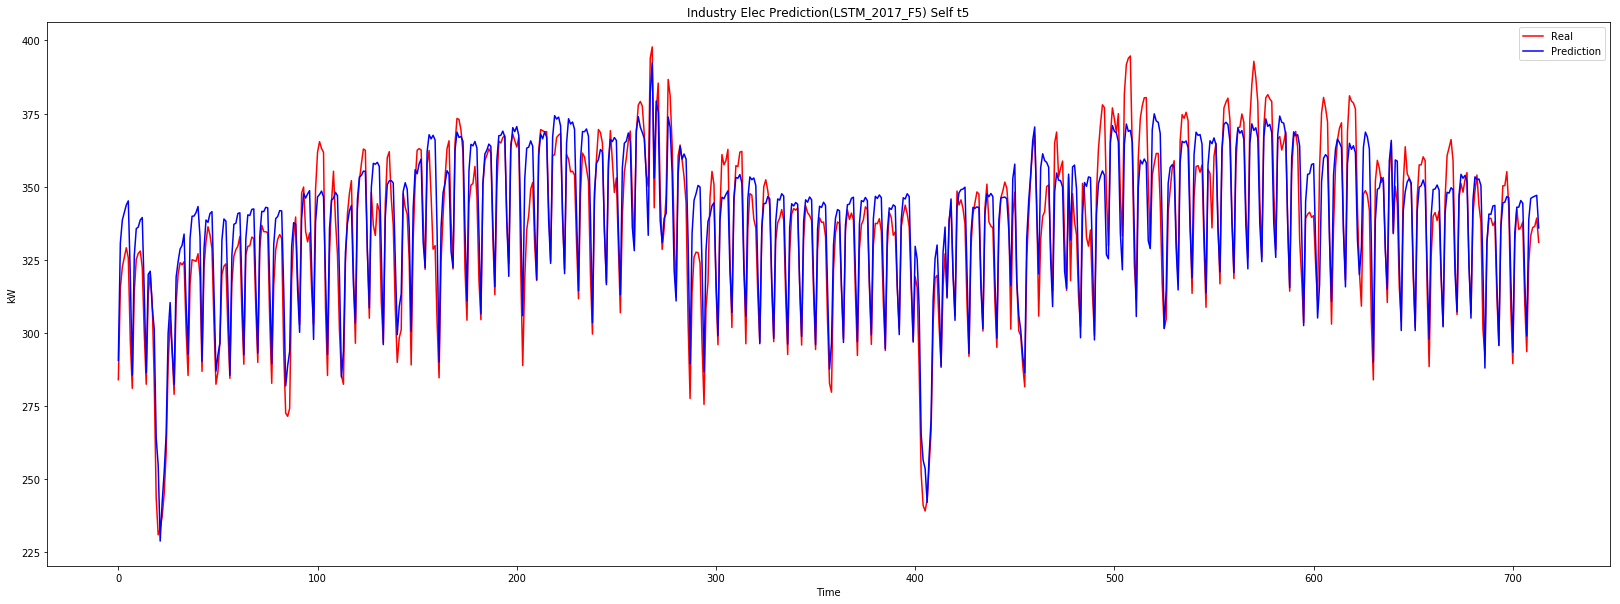

In [259]:
print("RMSE: ", rmse(self_true, self_prediction))
print("MAPE: ", mean_absolute_percentage_error(self_true, self_prediction))
showPlot(self_true, self_prediction, model_name, 'Self', 'L', save=save)

---
## Test-Prediction

In [260]:
# 預測時長(1單位 = 7天)
# Pre_step = 1
# Pre_step = 4
Pre_step = 39

In [261]:
# 真實值
pre_time = 7 * Pre_step
test_set = pd.DataFrame(RawTest[["工業用電(百萬度)"]])
test_set = test_set[:pre_time]
real_elec = test_set.values

# 訓練資料
X_test = buildTest(730, sc, Timesteps, OutputDay, Pre_step)

X_test.shape (39, 7, 11)


In [262]:
test_predict = model.predict(X_test)
test_predict = test_predict * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]

# Append Data
test_prediction = []
for i in range(Pre_step):
    test_prediction= np.concatenate((test_prediction, test_predict[i]), axis=0)
# Reshape
test_prediction = np.reshape(test_prediction, (real_elec.shape[0], real_elec.shape[1]))

# shape
# print('real_elec.shape', real_elec.shape)
# print('test_prediction.shape', test_prediction.shape)

RMSE:  13.285226823678098
MAPE:  3.08739326623951


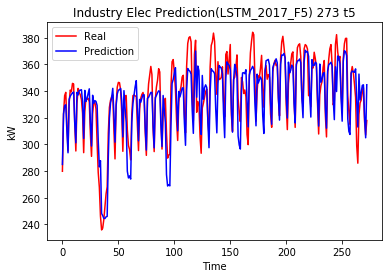

In [263]:
print("RMSE: ", rmse(real_elec, test_prediction))
print("MAPE: ", mean_absolute_percentage_error(real_elec, test_prediction))
showPlot(real_elec, test_prediction, model_name , str(pre_time), save=save)

---
## Save Model

In [118]:
# import h5py
# Model.save('Model/industryElec_cLSTM(7to7)_model_01.h5')